In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [33]:
model_dir = "outputs/models/w2v2_8/phoneme"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_dir = "out/ce_model_syllable_6_8"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_phonemes_by_identity_and_syllable_position.pkl"

metric = "cosine"

In [34]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [35]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [36]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

## Search for well-attested phonemes

In [37]:
# Build representation of all phoneme identities/positions
all_phonemes = sorted(set(phoneme for phoneme, position in state_space_spec.labels))
all_positions = sorted(set(position for phoneme, position in state_space_spec.labels if position is not None))
phoneme_mat = np.zeros((len(all_phonemes), len(all_positions)), dtype=int)
for i, (phoneme, position) in enumerate(state_space_spec.labels):
    if position is None:
        continue
    phoneme_mat[all_phonemes.index(phoneme), all_positions.index(position)] = \
        len(state_space_spec.target_frame_spans[i])
phoneme_df = pd.DataFrame(phoneme_mat, index=all_phonemes, columns=all_positions)
phoneme_df

,0,1,2,3,4,5,6
AA,2624,313,115,11,1,0,0
AE,3592,322,69,16,0,0,0
AH,4987,1808,853,280,124,27,1
AO,2580,318,33,7,2,0,0
AW,561,165,5,0,0,0,0
AY,1939,307,130,19,1,2,0
B,1657,500,183,45,26,1,0
CH,596,190,50,6,0,0,0
D,3984,1212,448,100,31,3,0
DH,2652,150,26,1,0,0,0


In [38]:
# Find phonemes which appear in every ordinal position at least twice up to `min_number_positions`
min_number_positions = 3
phoneme_max_position = (phoneme_df >= 2).idxmin(axis=1)
match_phonemes = phoneme_max_position.loc[phoneme_max_position >= min_number_positions].index.tolist()
len(match_phonemes), match_phonemes[:5]

(40, ['AA', 'AE', 'AH', 'AO', 'AW'])

<Axes: xlabel='ordinal_position', ylabel='frequency'>

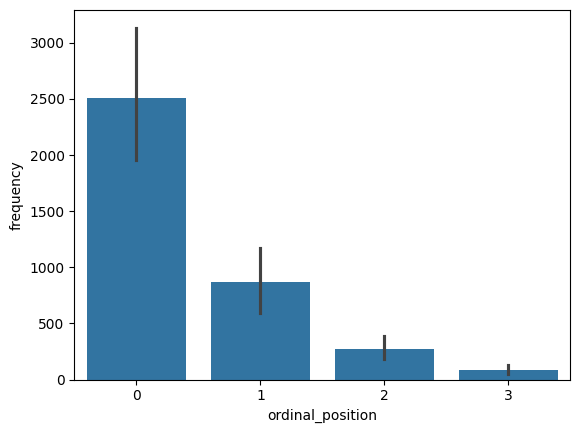

In [39]:
sns.barplot(data=phoneme_df.loc[match_phonemes, :min_number_positions] \
                    .melt(var_name="ordinal_position", value_name="frequency"),
            x="ordinal_position", y="frequency")

## Prepare model representations

In [40]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [41]:
retain_labels = [(phoneme, ordinal) for phoneme in match_phonemes
                 for ordinal in range(min_number_positions)]
retain_idxs = [state_space_spec.labels.index(label) for label in retain_labels]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [42]:
spec_label_strs = [f"{phone} {ordinal}" for phone, ordinal in state_space_spec.labels]

In [43]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [44]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [45]:
len(trajectory)

120

In [46]:
def get_mean_distance(samp1, samp2, metric=None):
    distances = cdist(samp1, samp2, metric=metric)
    distances = np.triu(distances, k=1)
    return distances[distances != 0].mean()

## Estimate within-phoneme, within-position distance

In [47]:
max_num_instances = 50
within_distance = np.zeros((len(trajectory), trajectory[0].shape[1])) * np.nan
for i, (trajectory_i, lengths_i) in enumerate(zip(tqdm(trajectory), lengths)):
    within_distance_i = []
    num_instances, num_frames, num_dims = trajectory_i.shape

    num_instances_limited = min(num_instances, max_num_instances)
    idxs = np.random.choice(num_instances, size=num_instances_limited, replace=False)
    samples_i, sample_lengths_i = trajectory_i[idxs], lengths_i[idxs]
    for j in range(num_frames):
        mask = sample_lengths_i >= j
        if mask.sum() <= 1:
            break
        within_distance[i, j] = get_mean_distance(samples_i[mask, j, :], samples_i[mask, j, :], metric=metric)

  0%|          | 0/120 [00:00<?, ?it/s]

<Axes: >

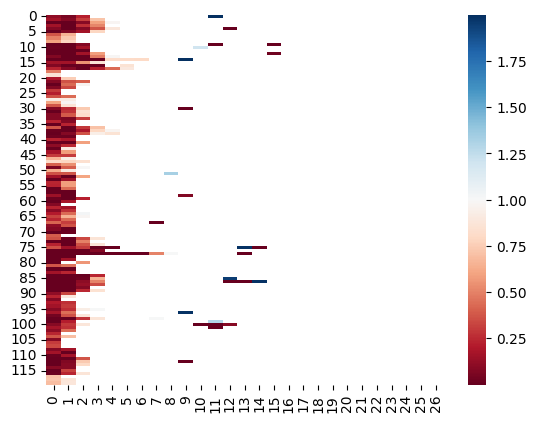

In [48]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [49]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

<Axes: xlabel='frame', ylabel='distance'>

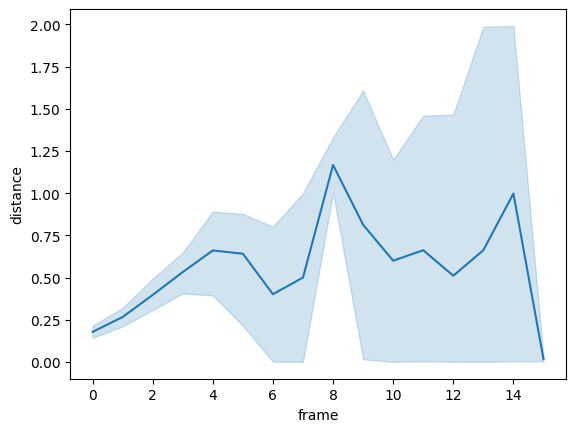

In [50]:
sns.lineplot(data=within_distance_df, x="frame", y="distance")

## Estimate within-phoneme, between-position distance

In [51]:
between1_samples = [[state_space_spec.labels.index((phoneme_i, ordinal_j))
                     for ordinal_j in range(min_number_positions)
                     if ordinal_j != ordinal_i]
                    for phoneme_i, ordinal_i in state_space_spec.labels]
between1_distances = np.zeros((len(trajectory), trajectory[0].shape[1], min_number_positions - 1)) * np.nan
for i, between1_samples_i in enumerate(tqdm(between1_samples)):
    traj_i, lengths_i = trajectory[i], lengths[i]
    if traj_i.shape[0] > max_num_instances:
        idxs = np.random.choice(traj_i.shape[0], size=max_num_instances, replace=False)
        traj_i = traj_i[idxs]
        lengths_i = lengths_i[idxs]
    
    for j, between1_sample in enumerate(between1_samples_i):
        traj_j, lengths_j = trajectory[between1_sample], lengths[between1_sample]
        if traj_j.shape[0] > max_num_instances:
            idxs = np.random.choice(traj_j.shape[0], size=max_num_instances, replace=False)
            traj_j, lengths_j = traj_j[idxs], lengths_j[idxs]
        
        for k in range(trajectory[0].shape[1]):
            mask_i = lengths_i >= k
            mask_j = lengths_j >= k
            if mask_i.sum() == 0 or mask_j.sum() == 0:
                break
            between1_distances[i, k, j] = get_mean_distance(traj_i[mask_i, k, :], traj_j[mask_j, k, :], metric=metric).mean()

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_1465306/904010836.py:4: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [52]:
between1_distances_df = pd.DataFrame(np.nanmean(between1_distances, axis=-1),
                                     index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_1465306/2302145081.py:1: RuntimeWarning: Mean of empty slice
  between1_distances_df = pd.DataFrame(np.nanmean(between1_distances, axis=-1),


<Axes: xlabel='frame', ylabel='distance'>

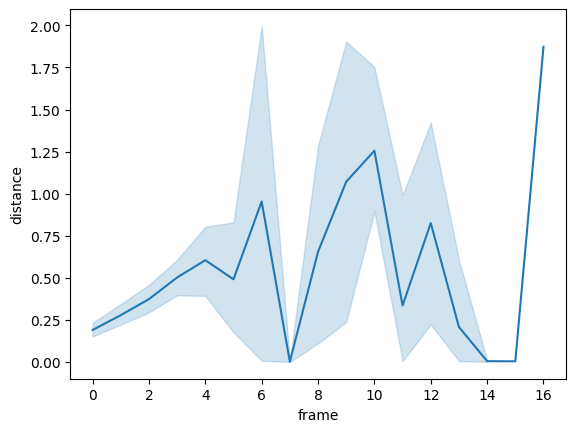

In [53]:
sns.lineplot(data=between1_distances_df, x="frame", y="distance")

## Estimate between-phoneme distance

In [54]:
# Match the number of between-samples with the earlier analysis
num_samples = min_number_positions

max_num_instances = 50
between_samples = [np.random.choice(list(range(idx)) + list(range(idx + 1, len(trajectory))),
                                    num_samples, replace=False)
                   for idx in range(len(trajectory))]
between_distances = np.zeros((len(trajectory), trajectory[0].shape[1], num_samples)) * np.nan
for i, between_samples_i in enumerate(tqdm(between_samples)):
    traj_i, lengths_i = trajectory[i], lengths[i]
    if traj_i.shape[0] > max_num_instances:
        idxs = np.random.choice(traj_i.shape[0], size=max_num_instances, replace=False)
        traj_i = traj_i[idxs]
        lengths_i = lengths_i[idxs]
    
    for j, between_sample in enumerate(between_samples_i):
        traj_j, lengths_j = trajectory[between_sample], lengths[between_sample]
        if traj_j.shape[0] > max_num_instances:
            idxs = np.random.choice(traj_j.shape[0], size=max_num_instances, replace=False)
            traj_j, lengths_j = traj_j[idxs], lengths_j[idxs]
        
        for k in range(trajectory[0].shape[1]):
            mask_i = lengths_i >= k
            mask_j = lengths_j >= k
            if mask_i.sum() == 0 or mask_j.sum() == 0:
                break
            between_distances[i, k, j] = get_mean_distance(traj_i[mask_i, k, :], traj_j[mask_j, k, :], metric=metric).mean()

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_1465306/904010836.py:4: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [55]:
between_distances_df = pd.DataFrame(np.nanmean(between_distances, axis=-1),
                                    index=pd.Index(spec_label_strs, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_1465306/1293829715.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distances, axis=-1),


<Axes: xlabel='frame', ylabel='distance'>

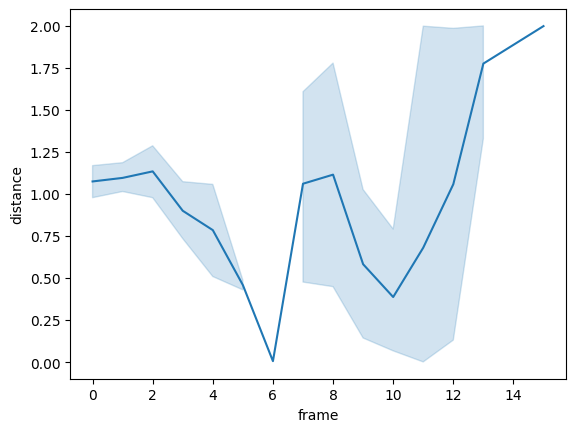

In [56]:
sns.lineplot(data=between_distances_df, x="frame", y="distance")

## Together

In [57]:
merged_df = pd.concat([within_distance_df.assign(type="within"),
                       between1_distances_df.assign(type="different_position"),
                       between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,phoneme,frame,distance,type
0,AA 0,0,0.115257,within
1,AA 1,0,0.156911,within
2,AA 2,0,0.003139,within
3,AE 0,0,0.162364,within
4,AE 1,0,0.084634,within
...,...,...,...,...
3235,ZH 1,26,NaN,between
3236,ZH 2,26,NaN,between
3237,[SIL] 0,26,NaN,between
3238,[SIL] 1,26,NaN,between


(0.0, 9.0)

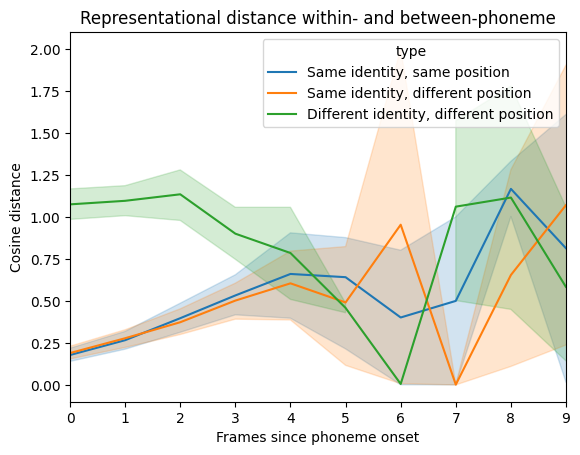

In [58]:
ax = sns.lineplot(data=merged_df.dropna().replace({"type": {"within": "Same identity, same position",
                                                            "different_position": "Same identity, different position",
                                                            "between": "Different identity, different position"}}),
                  x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-phoneme")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")
ax.set_xlim((0, np.percentile(np.concatenate(lengths), 95)))